# Python: Log-Odds Effects for Logistic PLR models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the changes in log-odds due to treatment in a logistic partíal linear regression [DoubleMLLPLR](https://docs.doubleml.org/stable/guide/models.html#logistic-partial-linear-regression-lplr) model.

In [16]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import doubleml as dml

from doubleml.plm.datasets import make_lplr_LZZ2020

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is adapted and extended from [Liu et al. (2020)](https://academic.oup.com/ectj/article-abstract/24/3/559/6296639).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/stable/api/datasets.html).

The data generation process supports both binary and continuous treatments. In this example we consider a continuous treatment effect. Both the treatment assignment (if binary) and the outcome variable balancing can be can be adjusted.

In [2]:
np.random.seed(42)
data = make_lplr_LZZ2020(n_obs=1000, dim_x=20, alpha=0.5, treatment="continuous")
print(data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20']
Instrument variable(s): None
No. Observations: 1000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 23 entries, X1 to p
dtypes: float64(23)
memory usage: 179.8 KB



## Model

The logistic partial linear regression (LPLR) model is specified as follows:

$$\mathbb{E} [Y | D, X] = \mathbb{P} (Y=1 | D, X) = \text{expit} \{\beta_0 D + r_0 (X) \}$$

where $Y$ is the binary outcome variable and $D$ is the policy variable of interest.
The high-dimensional vector $X = (X_1, \ldots, X_p)$ consists of other confounding covariates.
$\text{expit}$ is the logistic link function

$$\text{expit} ( X ) = \frac{1}{1 + e^{-x}}$$

The log-odds of the treated versus the untreated is modelled as a partial linear model. The estimated coefficient $\beta_0$ can be interpreted as the change in log-odds due to a one unit increase in the treatment variable $D$, holding all other covariates constant.

Next, define the learners for the nuisance functions and fit the [LPLR Model](https://docs.doubleml.org/stable/guide/models.html#logistic-partial-linear-regression-lplr).
The correct type of learner (regressor or classifier) must be used for each nuisance function.

- ml_M is a model of the outcome. Here, since the outcome is binary, we use a classifier.
- ml_t is a model of the log-odds. This must always be a regressor.
- ml_m is a model of the treatment. Here, since the treatment is continuous, we use a regressor. In the case of a binary treatment, a classifier must be used.

In [3]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor()
randomForest_class = RandomForestClassifier()

np.random.seed(4242)

dml_lplr = dml.DoubleMLLPLR(data,
                          ml_M=randomForest_class,
                          ml_t=randomForest_reg,
                          ml_m=randomForest_reg,
                          n_folds=5)
print("Training LPLR Model")
dml_lplr.fit()

print(dml_lplr.summary)

Training LPLR Model
      coef   std err         t     P>|t|     2.5 %    97.5 %
d  0.35212  0.100429  3.506179  0.000455  0.155284  0.548957


## Visualizations
We can plot the estimated probabilites from the nuisance function and compare with the observed outcome. We observe that there is good overlap of observed outcomes and accross the range of treatment variable D. Further, the probability estimate from the confounders is independent of the treatment variable D, as expected.

Text(0.5, 1.0, 'Estimated Outcome Probabilities from Confounding')

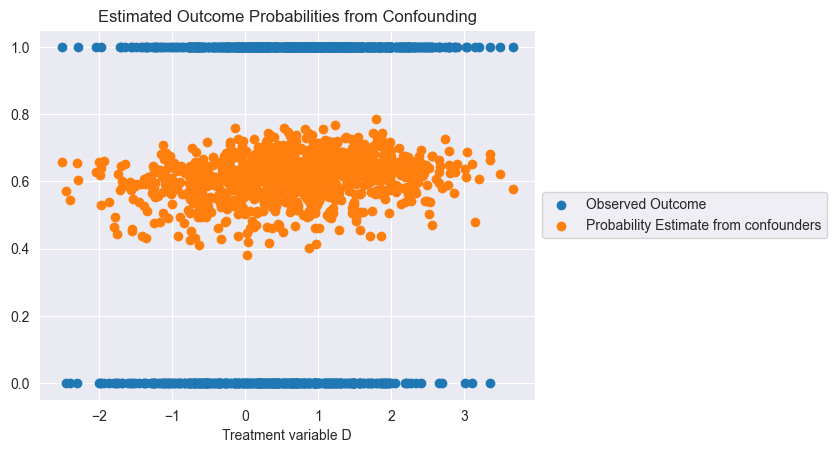

In [17]:
probability = dml_lplr.psi_elements["r_hat"].squeeze() # + dml_lplr.psi_elements["d"].squeeze() * 0.5
probability = scipy.special.expit(probability)

plt.scatter(dml_lplr.psi_elements["d"].squeeze(), dml_lplr.psi_elements["y"].squeeze(), label="Observed Outcome")
plt.scatter(dml_lplr.psi_elements["d"].squeeze(), probability, label="Probability Estimate from confounders")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Treatment variable D")
plt.title("Estimated Outcome Probabilities from Confounding")

Next, we look at the estimated probability only based on the treatment assignment, as well as the overall probability estimate of the LPLR model.

Text(0.5, 1.0, 'Estimated Outcome Probabilities from Confounding')

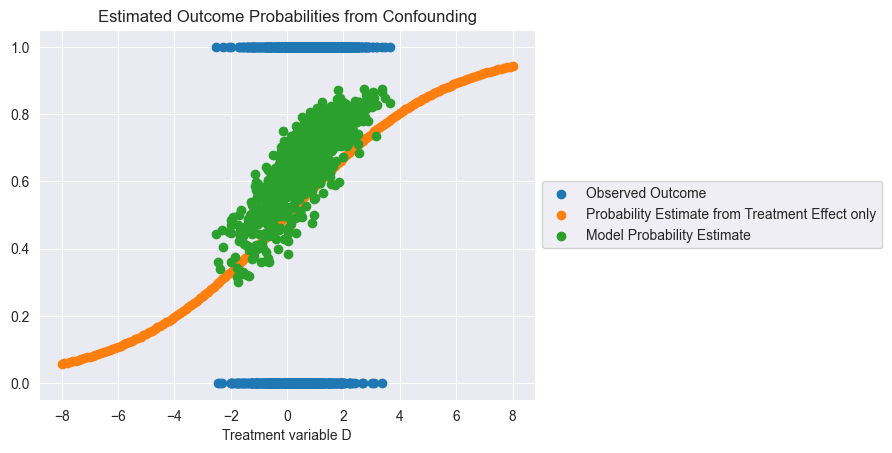

In [20]:
x = np.arange(-8, 8.1, 0.1)
probability_from_treatment = x* dml_lplr.coef.squeeze()
probability_from_treatment = scipy.special.expit(probability_from_treatment)

joint_probability = dml_lplr.psi_elements["r_hat"].squeeze() + dml_lplr.psi_elements["d"].squeeze() * dml_lplr.coef.squeeze()
joint_probability = scipy.special.expit(joint_probability)

plt.scatter(dml_lplr.psi_elements["d"].squeeze(), dml_lplr.psi_elements["y"].squeeze(), label="Observed Outcome")
plt.scatter(x, probability_from_treatment, label="Probability Estimate from Treatment Effect only")
plt.scatter(dml_lplr.psi_elements["d"].squeeze(), joint_probability, label="Model Probability Estimate")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("Treatment variable D")
plt.title("Estimated Outcome Probabilities from Confounding")

Note: The line and scatter are not perfectly aligned as the expit function is not additive. However, we can see that the treatment effect shifts the overall probability estimate up or down depending on the value of D.